In [1]:
import torch
import util.util as util
from data import create_dataloader
from models import create_model
from options.test_options import TestOptions
from options.train_options import TrainOptions
from util import html
from util.visualizer import Visualizer

import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
# set up options

args = ['--name', 'rcm2shg20230228',
        '--dataset_mode', 'rcm2shg',
        '--dataroot','/home/jessew/engrprojects/WilsonGroup/MRA_grant/aim1/data/20210617_ongoing/FOV300_pruned',
        '--netG','pix2pixhd']

sys.argv = args
opt = TestOptions().parse()

opt.name = 'rcm2shg20230228'
opt.phase = 'test'
opt.gpu_ids=[0]
opt.num_threads=1
opt.use_eval_mode=True
opt.inception_weights='fid_inception'
opt.batch_size=1
opt.evaluation_metrics='fid'
opt.serial_batches=True
opt.use_wandb=False
opt.no_flip=True
opt.no_flip_vert=True
opt.no_rotate=True
opt.which_epoch='latest'
opt.pretrained_netF = True


**************** AFTER BASIC OPTIONS *************************
Namespace(G_eval_mode=False, aspect_ratio=1.0, batch_size=1, cache_filelist_read=False, cache_filelist_write=False, checkpoints_dir='./checkpoints', condition_run_stats=False, contain_dontcare_label=False, crop_size=512, data_augmentation=None, dataroot='/home/jessew/engrprojects/WilsonGroup/MRA_grant/aim1/data/20210617_ongoing/FOV300_pruned', dataset_mode='rcm2shg', display_winsize=512, ema=0.0, evaluation_metrics='none', exp_id=None, gpu_ids='0', inception_weights='fid_inception', init_type='xavier', init_variance=0.02, label_nc=182, load_from_opt_file=False, load_size=512, max_dataset_size=9223372036854775807, model='contrastive_pix2pix', nThreads=4, name=None, nef=16, netF='vgg19', netG='pix2pixhd', ngf=64, no_flip=True, no_flip_vert=True, no_input_semantics=False, no_instance=False, no_rotate=True, norm_D='spectralinstance', norm_E='spectralinstance', norm_G='spectralinstance', num_test=inf, output_nc=3, perceptual_enc

In [3]:
dataset = create_dataloader(opt)
train_dataset = create_dataloader(util.copyconf(opt, phase="train"))

dataset [Rcm2shgDataset] of size 1040 was created
dataset [Rcm2shgDataset] of size 4221 was created


/usr/lib/python3/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


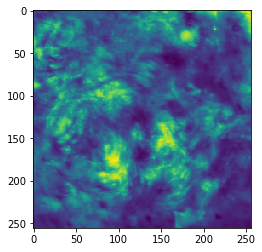

In [4]:
plt.imshow(train_dataset.dataset[0]['label'].squeeze().numpy())
plt.show()

In [5]:
model = create_model(opt)
model.eval()

Network [Pix2PixHDGenerator] was created. Total number of parameters: 182.4 million. To see the architecture, do print(network).
setting encoder to vgg19
initialize network with xavier
'VGG19' object has no attribute 'setup_hooks'


/usr/lib/python3/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


create mlp during runtime at device cpu
Network [ContrastiveEncoder] was created. Total number of parameters: 13.6 million. To see the architecture, do print(network).
loaded:latest_net_G.pth
loaded:latest_net_F_q.pth
model [ContrastivePix2PixModel] was created


ContrastivePix2PixModel(
  (netG): Pix2PixHDGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Sequential(
        (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (2): ReLU()
      (3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (4): ReLU()
      (5): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (6): ReLU()
      (7): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, aff

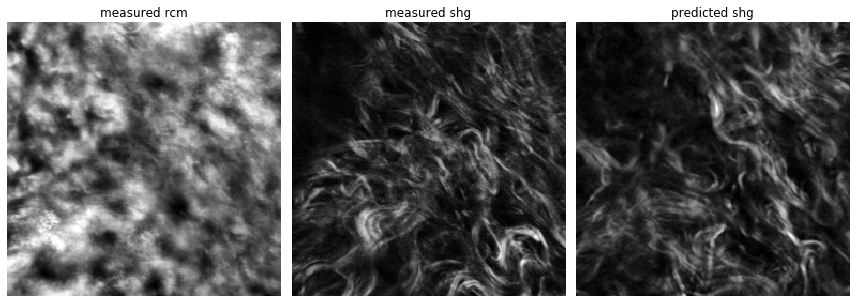

In [93]:
data = dataset.dataset[np.random.randint(len(dataset))]
data['label'] = data['label'][None,:]
data['image'] = data['image'][None,:]

generated = model(data,mode='inference')

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(data['label'].cpu().numpy().squeeze(),cmap='gray')
plt.axis('off')
plt.title('measured rcm')
plt.subplot(132)
plt.imshow(data['image'].cpu().numpy().squeeze(),cmap='gray')
plt.axis('off')
plt.title('measured shg')
plt.subplot(133)
plt.imshow(generated.cpu().numpy().squeeze(),cmap='gray')
plt.axis('off')
plt.title('predicted shg')
plt.tight_layout()
plt.show()

In [52]:
len(train_dataset)

4221

In [59]:
np.random.randint(len(dataset))

843

In [100]:
n = len(dataset)
mae_test = np.zeros(n)
mse_test = np.zeros(n)
pearson_test = np.zeros(n)

for i, data in enumerate(dataset):
    generated = model(data,mode='inference')
    
    mae_test[i] = torch.mean( torch.abs(generated - data['image']) )
    mse_test[i] = torch.mean( (generated - data['image'])**2 )
    
    generated_meansub = generated-torch.mean(generated)
    target_meansub = data['image'] - torch.mean(data['image'])
    
    pearson_test[i] = torch.sum( generated_meansub * target_meansub ) / torch.sqrt( torch.sum( generated_meansub**2 ) * torch.sum(target_meansub**2)  )
    
                     

In [107]:
n = len(train_dataset)
mae_train = np.zeros(n)
mse_train = np.zeros(n)
pearson_train = np.zeros(n)

for i, data in enumerate(train_dataset):
    generated = model(data,mode='inference')
    
    mae_train[i] = torch.mean( torch.abs(generated - data['image']) )
    mse_train[i] = torch.mean( (generated - data['image'])**2 )
    
    generated_meansub = generated-torch.mean(generated)
    target_meansub = data['image'] - torch.mean(data['image'])
    
    pearson_train[i] = torch.sum( generated_meansub * target_meansub ) / torch.sqrt( torch.sum( generated_meansub**2 ) * torch.sum(target_meansub**2)  )
    

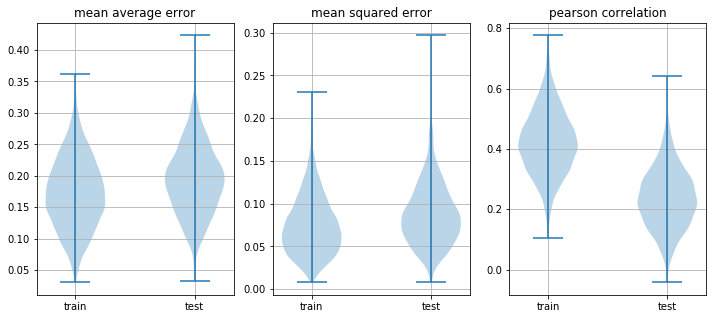

In [117]:
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.violinplot([mae_train,mae_test])
plt.grid()
plt.xticks([1, 2],['train','test'])
plt.title('mean average error')
plt.subplot(132)
plt.violinplot([mse_train,mse_test])
plt.grid()
plt.xticks([1, 2],['train','test'])
plt.title('mean squared error')
plt.subplot(133)
plt.violinplot([pearson_train,pearson_test])
plt.grid()
plt.xticks([1, 2],['train','test'])
plt.title('pearson correlation')

plt.show()
